In [1]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm          
sys.path.insert(0, '../Modules')
import erqMedSpec 
import erqScaling
from line_db import line_db
import os
from scipy import interpolate
from scipy.io import loadmat
# Reading data
# smp=Table.read('/home/reza/erq/sampling/org_sample2.fits')
smp=Table.read('../LumMatch/LumMatch.fits')
W3_0=smp['ABw3']
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
z_dr12=smp['z_dr12']
plate = smp['Plate']
mjd = smp['MJD']
fiberid= smp['FiberID']
iz_0 = iW3_0 - smp['r-w3'] + smp['r-z']
Lum_0 = smp['Lum']
np.savetxt('../IsoSurf/data3d.dat', np.array(list(zip(iW3_0, rew_0, kt80_0))))

In [2]:
## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
# selection parameters
nqsos = len(z_dr12)

# Enclosing_ratio=[0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
# for enclosing_ratio in Enclosing_ratio:  
colors=['green', 'orange', 'magenta', 'navy', 'red']
#########################Med-Spec####################################
enclosing_ratio= 0.99
cone_direction=0
# for coeff in [0.85, 0.9, 0.95, 1, 1.05, 1.10, 1.15]:
labels = loadmat('../IsoSurf/labels-coeff-0.65-r-%.2f.mat'%enclosing_ratio)
labels= np.array(labels["labels"])
bin_label=labels[0]
nBins = np.int32(max(bin_label))
bin_pop = np.zeros([nBins])

In [48]:
for b in range(1, nBins):
    bin_pop[b] = sum(bin_label==b+1) 


    print('bin:', b, '#', bin_pop[b])
    if(bin_pop[b]>5):
        sp = np.zeros([int(bin_pop[b]), nw])
        k=-1
        for i in tqdm(range(nqsos)):
            if(bin_label[i]==b+1):
                k+=1
            # Retrieve the spectra:
                file = '/media/reza/My Passport/erq/fred/sdss/%d/spec-%d-%d-%04d.fits' % (plate[i], plate[i],mjd[i],fiberid[i])
                spec = erqMedSpec.readDR10spec(file)
                wave = spec['wl']
                wz = wave/(z_dr12[i]+1)
                flux = spec['flux']
                mask = (wz > 1680.0) & (wz < 1730.0)
                fnorm = np.median(flux[mask])
                fluxn = flux/fnorm
            # interpolate the rest-frame spectrum onto the standard grid
                f = interpolate.interp1d(wz,fluxn,bounds_error=False,fill_value=float('nan'))
                sp[k] = f(wgrid)
            # calculate the median spectrum

        med1 = np.nanmedian(sp,axis=0)
        np.savetxt( '3d-cone-kde/kde-medspec-r-%.2f-bin-%d-cone-%d.txt' 
        %(enclosing_ratio, b, cone_direction), med1)

  0%|          | 15/29072 [00:00<03:37, 133.60it/s]

bin: 1 # 1040.0


100%|██████████| 29072/29072 [01:46<00:00, 273.31it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


FileNotFoundError: [Errno 2] No such file or directory: '3d-cone-kde/kde-medspec-r-0.99-bin-1-cone-0.txt'

bin: 1 1150 to 1700
bin: 2 1150 to 1700
bin: 3 1150 to 1700
bin: 4 1150 to 1700
bin: 5 1150 to 1700
bin: 6 1150 to 1700
bin: 7 1150 to 1700


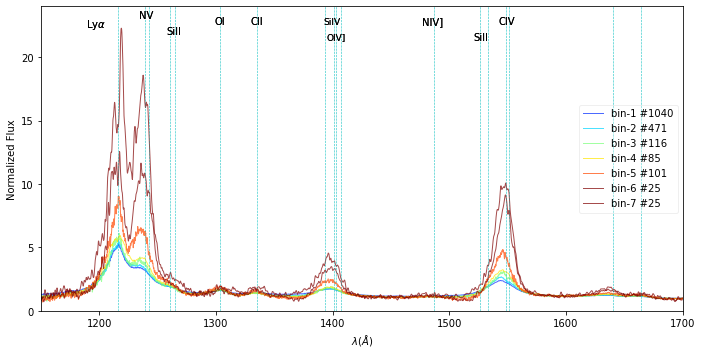

In [42]:
# plotting
from scipy import interpolate
# import pyfits
from numpy import *
import math
import scipy.ndimage
from scipy import interpolate
from numpy import nanmean
from numpy import nanmedian
from readSDSSspectrafast import *
from scipy import ndimage
from line_db import line_db
import os
from matplotlib import cm
#  nqsos is the total number of quasars in the catalog.
# zdr12 is the redshift from the DR12 catalog. You might use something else.
# zp1 is z+1
cone_direction=0
nqsos = len(z_dr12)



# labels = loadmat('../IsoSurf/labels-')
# labels= np.array(labels["labels"])
# bin_label=labels[0]
# nBins = np.int32(max(bin_label))
# bin_pop = np.zeros([nBins])
for b in range(nBins):
    bin_pop[b] = sum(bin_label==b+1)

ymax=24
ymin=-0.05*ymax
fs=10
fs1=9

y_median = 0.9*ymax
med_step=1
legend_loc=7
c = cm.get_cmap('jet', 7)

dir ='3d-cone+LOF/'
for ii in range(3,4):

    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))
    line_db(ymax, fs, fs1, lambda_max)

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    # plt.axes().set_aspect('equal')
    x_median=lambda_min+100


#         for b in range(len(bin_pop)-1,-1,-1):
    for b in range(1,nBins):

        if(bin_pop[b]>5):   
            print('bin:', b, lambda_min, 'to', lambda_max)
            med1=loadtxt('3d-cone-kde/kde-medspec-r-%.2f-bin-%d-cone-%d.txt' %(enclosing_ratio, b, cone_direction))
            plt.ylabel('Normalized Flux')
            plt.xlabel(r'$\lambda  (\AA)$')
            w3_bin=[]
            imw3_bin=[]
            REW_bin=[]
            fwhm_bin=[]
            kt80_bin=[]
            frat_bin=[]
            iz_bin=[]
            Lum_bin=[]

            for i in range(nqsos):
                if(bin_label[i]==b+1):
                    w3_bin.append(W3_0[i]) 
                    imw3_bin.append(iW3_0[i])
                    REW_bin.append(int(10**rew_0[i]))
                    fwhm_bin.append(fwhm_0[i])
                    kt80_bin.append(kt80_0[i])
                    frat_bin.append(frat_0[i])
                    iz_bin.append(iz_0[i])
                    Lum_bin.append(Lum_0[i])
            if(bin_pop[b]<100):
                sm_med1 = ndimage.filters.gaussian_filter1d(med1,2.0)
            else:
                sm_med1=med1

            # masking for plot ranges
            ind = (wgrid>lambda_min) & (wgrid<lambda_max)
            if b==0:

                plt.plot(wgrid[ind],  sm_med1[ind], lw = 3, alpha=0.4, c=c(b), 
                         label='bin-C #%d' %bin_pop[b])
            else:
                 plt.plot(wgrid[ind],  sm_med1[ind], lw = 1, c=c(b), 
                         label='bin-%d #%d' %(b, bin_pop[b]), alpha=0.7)
#             plt.text(x_median, y_median -(b+1)*med_step,
#                      'bin%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
#                      %(b+1, bin_pop[b], np.median(imw3_bin),  
#                         np.median(REW_bin), np.median(fwhm_bin),  
#                         np.median(kt80_bin), np.median(frat_bin), 
#                         np.median(iz_bin)), 
#                      ha='left', va='center', color=colors[b], fontsize=7)

#         plt.text(x_median, y_median -(b+1)*med_step,
#                          'bin%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
#                          %(b+1, bin_pop[b], np.median(imw3_bin),  
#                             np.median(REW_bin), np.median(fwhm_bin),  
#                             np.median(kt80_bin), np.median(frat_bin), 
#                             np.median(iz_bin)), 
#                          ha='left', va='center', color=c[b], fontsize=10)
    plt.legend(fancybox=True, framealpha=0.3, loc=legend_loc)
    line_db(ymax, fs, fs1, lambda_max)
#     plt.title('coeff=%.2f'  %coeff)
#         plt.title(r'$\Omega=%.2f^{\circ}$, r=%.2f, $\hat{u}$=[%.2f, %.2f, %.2f]' 
#                 %(np.rad2deg(opening_angle), 
#                   enclosing_ratio, cone_vec_3d[cone_direction,0],
#                   cone_vec_3d[cone_direction,1],
#                   cone_vec_3d[cone_direction,2]))
    fig_path = dir + '3d-r-%d-dir-%d-li-%d-lf-%d.png' %(enclosing_ratio*100, cone_direction, lambda_min,
                                                                lambda_max)
    plt.savefig(fig_path, format='png', dpi=400,  bbox_inches='tight')
    # os.system('evince '+ fig_path)
    # plt.savefig('/home/reza/erq/kde/bw/enc-r-%.2f/test.pdf' %(enclosing_ratio),format='pdf',  bbox_inches='tight')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()



0.65


  0%|          | 0/29072 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/29072 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

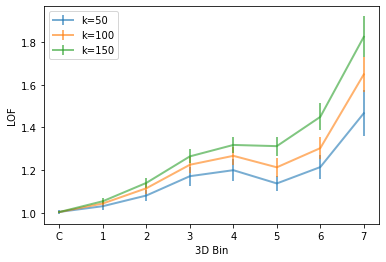

In [45]:
dir ='3d-cone+LOF/'
from sklearn.neighbors import LocalOutlierFactor as LOF
nBin=8
# for coeff in [0.8, 0.9, 1, 1.1, 1.2]:
for coeff in [0.65]:
    print(coeff)
    labels = loadmat('../IsoSurf/labels-coeff-%.2f-r-%.2f.mat'%(coeff, enclosing_ratio))
    labels= np.array(labels["labels"])
    bin_label=labels[0]
    nBins = np.int32(max(bin_label))

    data_0=np.array(list(zip(iW3_0, rew_0, kt80_0)))
    (data, minData, rangeData) =  erqScaling.MinMaxScaler(data_0)

    clf= LOF(n_neighbors=150,  n_jobs=8)
    clf.fit_predict(data)
    LOFScores= -clf.negative_outlier_factor_
#     for b in range(3,nBin):
#         plt.hist(LOFScores[bin_label==b+1], density=True, alpha=0.5, label=b+1)
#     plt.legend()
#     plt.show()
    
    for k in [50, 100, 150]:

        clf= LOF(n_neighbors=k,  n_jobs=4)
        clf.fit_predict(data)
        LOFScores= -clf.negative_outlier_factor_
        BootSize=np.int32(len(data))
        LOFScores_boot=np.zeros([100,len(data)])
        for b in tqdm(range(100)):
            rand_ind = np.random.choice(range(len(data)), BootSize, replace=True)
            test= data[rand_ind,:]
            clf= LOF(n_neighbors=k,  n_jobs=4)
            clf.fit_predict(test)
            LOFScores_boot[b,rand_ind] = -clf.negative_outlier_factor_
            LOFScores_boot[b,~rand_ind] = 0

        ErrLOF = np.zeros(len(data))
        MeanLOFBoot = np.zeros(len(data))
        for i in tqdm(range(len(data))):

            LOF_pool = LOFScores_boot[:,i]
            ErrLOF[i] = np.std(LOF_pool[LOF_pool>=1])
            # MeanLOFBoot[i] = np.mean(LOF_pool[LOF_pool<=-1])

        LOFScoresMed=[]
        ErrLOFScoresMed=[]
        MeanLOFBootMed=[]

        for b in range(nBin):
            mask = (bin_label==b+1)

            LOFScoresMed.append(np.mean(LOFScores[mask]))
            ErrLOFScoresMed.append(np.nanmean(ErrLOF[mask]))


        plt.errorbar(['C', '1', '2', '3', '4', '5', '6', '7'], LOFScoresMed[0:nBin], yerr=ErrLOFScoresMed[0:nBin], lw=2,
                     markersize=2, label='k=%d'%k, alpha=0.6)

    plt.legend()
    plt.xlabel('3D Bin')
    plt.ylabel('LOF')
#     plt.title('K=%d'%k)
    plt.savefig(dir+'LOF-%.2f-r-%.2f.png' %(coeff, enclosing_ratio), dpi=200, format='png')
    plt.show()


In [10]:
dir ='3d-cone+LOF/'

imw3_bin_med =[]
REW_bin_med = []
fwhm_bin_med = []
kt80_bin_med = []
frat_bin_med = []
iz_bin_med = []
Lum_bin_med = []
nBin=7
Bin=[]
BinPop=[]

for b in range(nBins):
    mask = (bin_label==b+1)
    BinPop.append(sum(mask))
    Bin.append("{0:.0f}".format(b+1))
    imw3_bin_med.append("{0:.2f}".format(np.median(iW3_0[mask==True])))
    REW_bin_med.append("{0:.0f}".format(np.median(10**(rew_0[mask==True]))))
    fwhm_bin_med.append("{0:.0f}".format(np.median(fwhm_0[mask==True])))
    kt80_bin_med.append("{0:.2f}".format(np.median(kt80_0[mask==True])))
    frat_bin_med.append("{0:.2f}".format(np.median(frat_0[mask==True])))
    iz_bin_med.append("{0:.2f}".format(np.median(iz_0[mask==True])))
    Lum_bin_med.append("{0:.2f}".format(np.median(Lum_0[mask==True])))

tabProperties = Table([Bin,BinPop, imw3_bin_med, REW_bin_med, fwhm_bin_med, kt80_bin_med, frat_bin_med, iz_bin_med, Lum_bin_med],
                      names=('Bin','nBin', 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum'))
tabProperties.write(dir + '3d-Properties.fits' , format='fits', overwrite=True)